<span style="color: Gold"> KoBERT
- BERT 기반 한국어 모델
- 구조/ 학습 방식은 BERT와 같음

In [3]:
%pip install sentencepiece

In [4]:
%pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer": Expected package name at the start of dependency specifier
    'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer
    ^
Hint: = is not a valid operator. Did you mean == ?
'subdirectory'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [5]:
%pip install kobert-tokenizer

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement kobert-tokenizer (from versions: none)
ERROR: No matching distribution found for kobert-tokenizer


In [6]:
%pip install kobert-transformers

In [ ]:
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tokenizer.encode("한국어 모델을 공유합니다.")

ModuleNotFoundError: No module named 'kobert_tokenizer'

In [2]:
tokenizer('한국어 모델을 공유합니다.')

NameError: name 'tokenizer' is not defined

In [ ]:
import torch
from transformers import BertModel
model = BertModel.from_pretrained('skt/kobert-base-v1')
text = "한국어 모델을 공유합니다."
inputs = tokenizer.batch_encode_plus([text])    # batch_encode_plus: HuggingFace 토크나이저에서 여러 문장을 한 번에 숫자 토큰 ID로 변환하고, 모델 입력용 필요한 모든 텐서를 만들어주는 함수
out = model(input_ids = torch.tensor(inputs['input_ids']),
              attention_mask = torch.tensor(inputs['attention_mask']))
out.pooler_output.shape

<span style="color: lightblue;"> batch_encode_plus가 자동으로 생성하는 것

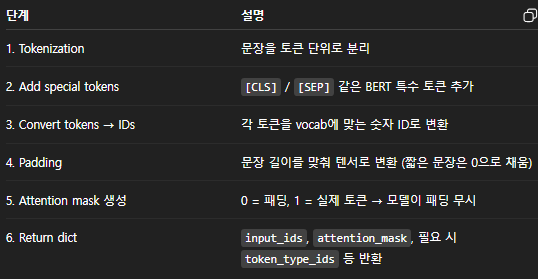


<span style="color: lightblue;"> 파이토치(BERT) 입력 구조


| 입력 이름       | 의미                     | 형태 (shape)                  |
|----------------|--------------------------|-------------------------------|
| input_ids      | 토큰 ID 시퀀스           | [batch_size, sequence_length] |
| attention_mask | 패딩 여부                 | [batch_size, sequence_length] |
| token_type_ids | 문장 A/B 구분용 (옵션)    | [batch_size, sequence_length] |

**설명:**
- `batch_size`       : 한 번에 모델에 넣는 문장 수
- `sequence_length`  : 각 문장의 토큰 길이 (패딩 포함)
- `attention_mask`   : 1 = 실제 토큰, 0 = 패딩
- `token_type_ids`   : 문장이 2개 이상일 때, 어느 문장에 속하는지 구분

In [ ]:
# 데이터셋클래스
import torch
class OurDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx].clone().detach()) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)


In [ ]:
# 데이터 로드 및 분할(여기서는 성능상 일부 데이터만 사용)
import pandas as pd
from sklearn.model_selection import train_test_split
# 데이터셋 로드
url = "https://drive.google.com/uc?id=1KOKgZ4qCg49bgj1QNTwk1Vd29soeB27o"
df = pd.read_csv(url)
print(len(df))
df = df.sample(frac=0.1)
print(len(df))
X = df.review.tolist()
y = (df.rating >= 6).values.astype(int)
x_,x_test,y_,y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=0.2)
x_train,x_val,y_train,y_val = train_test_split(x_,y_,stratify=y_, random_state=42,test_size=0.2)

In [ ]:
from torch.utils.data import DataLoader
# 토큰화
train_input = tokenizer(x_train, truncation=True, padding=True,return_tensors='pt')
val_input = tokenizer(x_val, truncation=True, padding=True, max_length=512,return_tensors='pt')
test_input = tokenizer(x_test, truncation=True, padding=True, max_length=512,return_tensors='pt')
# DataSet 생성
train_dataset = OurDataset(train_input,y_train)
val_dataset = OurDataset(val_input,y_val)
test_dataset = OurDataset(test_input,y_test)
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)
# KoBERT 한국어 전용 모델 로드
from transformers import BertModel
model = BertModel.from_pretrained('skt/kobert-base-v1')
# BERT를 포함한 신경망 모델
import torch.nn as nn
class MyModel(nn.Module):
  def __init__(self,prefrained_model, token_size, num_labels):
    super(MyModel,self).__init__()
    self.prefrained_model=prefrained_model
    self.token_size=token_size
    self.num_labels=num_labels
    # 분류기 정의
    self.clf = nn.Linear(self.token_size,self.num_labels)
  def forward(self,inputs):
    outputs = self.prefrained_model(**inputs)  # [batch,embeding_dim,num_labels]
    bert_clf_token = outputs.last_hidden_state[:,0,:]

    return self.clf(bert_clf_token)
model = MyModel(model,token_size = model.config.hidden_size,num_labels=2)
# 학습 - 미니배치
  # device
import torch
device = 'cuda' if torch.cuda.is_available()  else 'cpu'
model.to(device)
  # optimize
# AdamW import
from torch.optim import AdamW
# from torch. import AdamW
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
  # 학습 스케줄러
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(optimizer=optim,
                                            num_training_steps = len(train_loader),
                                            num_warmup_steps=200)
  # epoch수만큼 loop
for epoch in range(3):
  import numpy as np
  total_loss = 0
  for batch in train_loader:
    model.train()
    optim.zero_grad()
    # 배치에서는 label을 제외하고 입력만 추출
    inputs = {k : v.to(device) for k,v in batch.items() if k != 'labels'}
    labels = batch['labels'].to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optim.step()
    scheduler.step()
    total_loss += loss.item()
  print(f'epoch : {epoch+1}  train loss : {total_loss / len(train_loader)}')
  # val데이터로 해당 epoch 학습된 모델을 평가
  with torch.no_grad():
    model.eval()
    total_val_loss = 0
    for batch in val_loader:
      inputs = {k : v.to(device) for k,v in batch.items() if k != 'labels'}
      labels = batch['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()
    print(f'val_loss : {total_val_loss / len(val_loader)}')

In [ ]:
%pip install evaluate

In [ ]:
# 평가
import evaluate
metric = evaluate.load("accuracy")
model.eval()
with torch.no_grad():
  for batch in test_loader:
    inputs = {k : v.to(device) for k,v in batch.items() if k != 'labels'}
    labels = batch['labels'].to(device)
    outputs = model(inputs)
    predictions = torch.argmax(outputs, dim=-1)
    metric.add_batch(predictions=predictions, references=labels)
metric.compute()


In [ ]:
df2 = df.reset_index(drop=True)
df2[-5:].review.tolist()

In [ ]:
df2[-5:].review.values.tolist()

In [ ]:
import torch
inputs = tokenizer(df2[-5:].review.values.tolist(),padding=True,truncation=True,return_tensors='pt',max_length=512)
inputs = {k : v.to(device) for k,v in inputs.items()}
outputs = model(inputs)
preds = torch.softmax(outputs,dim = -1)
preds = torch.argmax(preds,dim=-1)
preds